# Lab 3 - Prior and Posterior predictive distributions

The goal of this excercise is to create a binomial model, use prior predictive distributions to select a proper prior and then using posterior predictive distributions.

We will be considering a following case:

Typical effects of administering certain vaccine result in an allergic reaction in 20% cases on average. This is what we know a priori

We are testing a new vaccine, for which we performed a trial on 50 patients registering 7 allergic reactions. We want to verify what is the allergic reaction probability for new trial and what is the probability that it is lower than for normal vacine. We assume that each patient treatment is exchangeable. 

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import seaborn as sns
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Modeling prior predictive distribution

Because prior predictive distribution does not use data it can often be realized just using random number generators. 

1. Create a Stan model, which will consist of only ```generated quantites``` block.
2. In this block define integer variable ```N``` for number of trials equal to 50, integer variable ```y``` for number of successes and real ```p``` for probability of allergic reaction. Remember to use necessary constraints.
3. Assign a prior for  ```p``` (appropriate random number generator) that will represent our knowledge about typical cases. You can do it either analytically or by using simulations. 
4. Sample from binomial distribution, that will use ```N``` and sampled ```p``` to generate number of allergic reactions ```y```.
5. Generate 1000 samples (pair of ```p``` an ```y```) by calling appropriate method in ```cmdstanpy```. Remeber to set ```fixed_param=True```.
6. Compute ratio of allergic reactions for each sample and create a histogram.
7. Verify if mean of the ratio is consistent with prior knowledge, otherwise modify prior parameters. Describe your reasoning in the report. 

Stan model 1.:
```stan
generated quantities {
    int<lower=0> N = 50;
    int<lower=0, upper=N> y;
    real<lower=0, upper=1> p;
    
    p = normal_rng(0.2, 0.05);
    y = binomial_rng(N, p);
}
```

In [2]:
# 1.1-1.5 Stan model
stan_model1 = CmdStanModel(stan_file='stan_codes/code_1.stan')
samples = stan_model1.sample(
    data={'N':50}, 
    fixed_param=True, 
    iter_sampling=1000, 
    iter_warmup=0, 
    chains = 1)

# Create pandas dataframe
df = samples.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,N,y,p
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,49.950000,9.857000,0.200187
std,0.0,0.0,1.581139,3.735037,0.051254
min,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,50.000000,7.000000,0.166492
50%,0.0,0.0,50.000000,10.000000,0.198217
75%,0.0,0.0,50.000000,12.000000,0.235481
max,0.0,0.0,50.000000,22.000000,0.355975


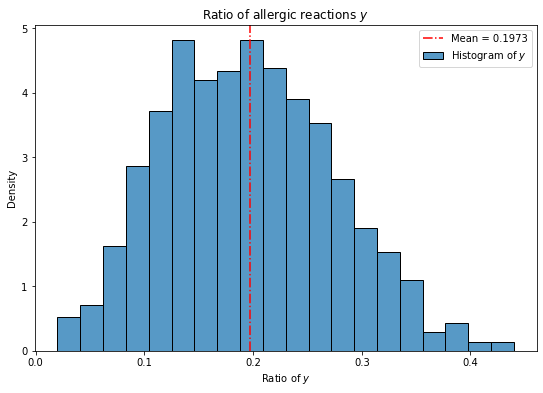

In [3]:
display(df.describe())

# 1.6 Compute ratio of [y-number of reactions] to [N-number of patients] (for each sample)
y_ratio = df['y'] / df['N']
mean_y_ratio = y_ratio.mean()

fig, ax = plt.subplots(figsize=(9, 6))
# Histogram of ratio'ed y
sns.histplot(data=y_ratio, bins=20, stat='density', ax=ax, label='Histogram of $y$')
# 1.7 Verify mean ratio
ax.axvline(x=mean_y_ratio, ymin=0, ymax=10, color='r', linestyle='-.', label=f'Mean = {mean_y_ratio:.4f}')
ax.set(title='Ratio of allergic reactions $y$', xlabel='Ratio of $y$', ylabel='Density')
ax.legend()
plt.show()

**1.7 Verify ratio mean consistency**  
As visible on graph above *(red line)* - mean of `y_ratio` is consistant with prior knowledge *(Probability of cases `p=0.20`)* and is also around `~0.20`


## 2. Modeling posterior and posterior predictive distribution

1. Create a Stan model in which:
   - ```N``` and ```y``` are appropriately defined in the ```data``` block.
   - ```p``` is defined in the parameters block. 
   - binomial likelihood and prior (selected using prior predictive distribution) are defined in the model block.
   - new integer variable ```y_pred``` in the generated quantities block. 
   - sample ```y_pred``` using values of parameter ```p``` and input variable ```N```
2. Generate default number of samples from appropriate method in ```cmdstanpy```.
3. Compute ratio of predicted allergic reactions for each sample and create a histogram.
4. Compute the expected value and 94% density interval of the predicted ratio, compare it with expected value and 94% density interval of parameter ```p```. Use ```arviz``` package.
5. Compute the probability that ratio is lower than the average probability from traditional vaccines (count the number of simulated ratios that are smaller).




In [578]:
# Model parameters
N = 50
y = 7

# 2.1 Stan model
stan_model2 = CmdStanModel(stan_file='stan_codes/code_2.stan')
# 2.2 Default number of samples
samples = stan_model2.sample(data={'N':N, 'y':y})

# Create pandas dataframe
df = samples.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


In [579]:
# 2.3 Compute ratio of
# [y_pred-predicted allergic reactions] to [N-number of patients] (for each sample)
df['y_pred_ratio'] = df['y_pred'] / N
mean_y_ratio = y_ratio.mean()

display(df[['p', 'y_pred', 'y_pred_ratio']].describe())

,p,y_pred,y_pred_ratio
count,4000.000000,4000.000000,4000.000000
mean,0.174780,8.765500,0.175310
std,0.037290,3.266141,0.065323
min,0.065139,0.000000,0.000000
25%,0.149493,6.000000,0.120000
50%,0.173608,9.000000,0.180000
75%,0.198996,11.000000,0.220000
max,0.326195,22.000000,0.440000


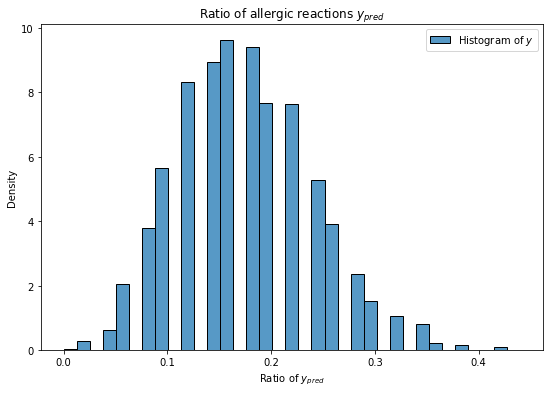

In [580]:
# 2.3 Histogram of ratio'ed y
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(data=df['y_pred_ratio'], bins='auto', stat='density', ax=ax, label='Histogram of $y$')
ax.set(title='Ratio of allergic reactions $y_{{pred}}$', xlabel='Ratio of $y_{{pred}}$', ylabel='Density')
ax.legend()
plt.show()

In [582]:
# 2.4 Expected value and 94% density interval for
# - predicted ratio
expected_y_pred = df['y_pred_ratio'].mean()
## Highest Density Interval (94%)
y_pred_HDI = az.hdi(df['y_pred_ratio'].to_numpy(), hdi_prob=0.94)

# - parameter [p]
expected_p = df['p'].mean()
## Highest Density Interval (94%)
p_HDI = az.hdi(df['p'].to_numpy(), hdi_prob=0.94)

print('Predicted y_ratio:')
print(f'- Expected value: {expected_y_pred:.4f}')
print(f'- 94%-density HDI: <{y_pred_HDI[0]:.4f}, {y_pred_HDI[1]:.4f}>')

print('Parameter [p]:')
print(f'- Expected value: {expected_p:.4f}')
print(f'- 94%-density HDI: <{p_HDI[0]:.4f}, {p_HDI[1]:.4f}>')

# 2.5 Probability for [ratio] lower then [average probability from traditional vaccines]
avg_p = 0.2     # Average probability
count_ratio_lower = np.sum(df['y_pred_ratio'] < avg_p)
prob_ratio_lower = count_ratio_lower / len(df['y_pred_ratio']) * 100

print(f'\nProbability that ratio is lower then avg-probability: {prob_ratio_lower:.2f}%')


Predicted y_ratio:
- Expected value: 0.1753
- 94%-density HDI: <0.0600, 0.3000>
Parameter [p]:
- Expected value: 0.1748
- 94%-density HDI: <0.1048, 0.2453>

Probability that ratio is lower then avg-probability: 61.25%
